In [39]:
from __future__ import print_function
import numpy as np
import pandas as pd
from keras.layers.core import Dense, Activation, Dropout
from keras.layers.recurrent import LSTM
from keras.models import Sequential

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import math

In [40]:
# parameters to be set ("optimum" hyperparameters obtained from grid search):
look_back = 7
epochs = 1000
batch_size = 32

In [41]:
# fix random seed for reproducibility
np.random.seed(7)

In [42]:
# read all prices using panda
prices_dataset =  pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Stock price.csv', header=0)

In [43]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [44]:
prices_dataset

,date,symbol,open,close,low,high,volume
0,2016-01-05,WLTW,123.430000,125.839996,122.309998,126.250000,2163600.0
1,2016-01-06,WLTW,125.239998,119.980003,119.940002,125.540001,2386400.0
2,2016-01-07,WLTW,116.379997,114.949997,114.930000,119.739998,2489500.0
3,2016-01-08,WLTW,115.480003,116.620003,113.500000,117.440002,2006300.0
4,2016-01-11,WLTW,117.010002,114.970001,114.089996,117.330002,1408600.0
...,...,...,...,...,...,...,...
851259,2016-12-30,ZBH,103.309998,103.199997,102.849998,103.930000,973800.0
851260,2016-12-30,ZION,43.070000,43.040001,42.689999,43.310001,1938100.0
851261,2016-12-30,ZTS,53.639999,53.529999,53.270000,53.740002,1701200.0
851262,2016-12-30,AIV,44.730000,45.450001,44.410000,45.590000,1380900.0


In [45]:
# filter out only data of CSCO
CSCO = prices_dataset[prices_dataset['symbol']=='CSCO']

In [46]:
# save CSCO's stock values as type of floating point number
CSCO_stock_prices = CSCO.close.values.astype('float32')

In [47]:
# reshape to column vector
CSCO_stock_prices = CSCO_stock_prices.reshape(len(CSCO_stock_prices), 1)

In [48]:
# normalize the dataset
scaler = MinMaxScaler(feature_range=(0, 1))
CSCO_stock_prices = scaler.fit_transform(CSCO_stock_prices)

In [49]:
# split data into training set and test set
train_size = int(len(CSCO_stock_prices) * 0.67)
test_size = len(CSCO_stock_prices) - train_size
train, test = CSCO_stock_prices[0:train_size,:], CSCO_stock_prices[train_size:len(CSCO_stock_prices),:]

print('Split data into training set and test set... Number of training samples/ test samples:', len(train), len(test))

Split data into training set and test set... Number of training samples/ test samples: 1180 582


In [51]:
# convert an array of values into a time series dataset 
# in form 
#                     X                     Y
# t-look_back+1, t-look_back+2, ..., t     t+1

def create_dataset(dataset, look_back):
	dataX, dataY = [], []
	for i in range(len(dataset)-look_back-1):
		a = dataset[i:(i+look_back), 0]
		dataX.append(a)
		dataY.append(dataset[i + look_back, 0])
	return np.array(dataX), np.array(dataY)

# convert CSCO's stock price data into time series dataset
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

In [52]:
# reshape input of the LSTM to be format [samples, time steps, features]
trainX = np.reshape(trainX, (trainX.shape[0], trainX.shape[1], 1))
testX = np.reshape(testX, (testX.shape[0], testX.shape[1], 1))

In [53]:
# create and fit the LSTM network
model = Sequential()
model.add(LSTM(4, input_shape=(look_back, 1)))
model.add(Dense(1))
model.compile(loss='mse', optimizer='adam')
model.fit(trainX, trainY, batch_size=batch_size)

37/37 [==============================] - 2s 4ms/step - loss: 0.0921


In [54]:
# make predictions
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

In [55]:
# invert predictions and targets to unscaled
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])

In [56]:
# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

Train Score: 3.09 RMSE
Test Score: 6.77 RMSE


In [57]:
# shift predictions of training data for plotting
trainPredictPlot = np.empty_like(CSCO_stock_prices)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict

# shift predictions of test data for plotting
testPredictPlot = np.empty_like(CSCO_stock_prices)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(CSCO_stock_prices)-1, :] = testPredict

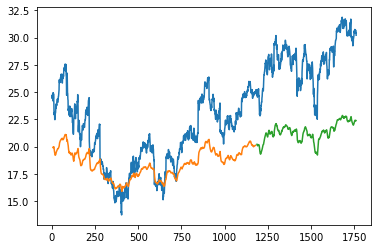

In [58]:
# plot baseline and predictions
plt.plot(scaler.inverse_transform(CSCO_stock_prices))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()